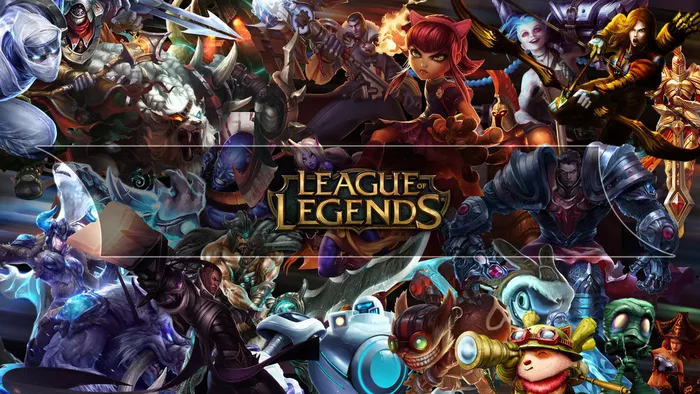

# Deciding Factors in League of Legends

### This notebooks tries to find out what are the key reasons a team wins/loses, and at the same time build a model predicting game results only using data from the first 10 mins. The data consists of SOLO QUEUE games at high ELO (DIAMOND I to MASTER)

### The algorithms used are:
* Random Forest
* Logistic Regression
* Principal Compnent Analysis (PCA)

### Summary of findings:

The two most important statistics on winning/losing are:
* Gold difference
* Experience difference

## Load Libraries

In [1]:
import numpy as np 
import pandas as pd

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# plotly
import plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
games_source = pd.read_csv('../input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv')

# Basic info

In [3]:
print('data dimension:', games_source.shape)
print('\n')
print('column names:', list(games_source.columns))
print('\n')
print('missing values:', games_source.isnull().any().sum())
print('\n')
games_source.head(10)

data dimension: (9879, 40)


column names: ['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin']


missing values: 0




gameId  blueWins  blueWardsPlaced  blueWardsDestroyed  blueFirstBlood  \
0  4519157822         0               28                   2               1   
1  4523371949         0               12                   1               0   
2  4521474530         0               15                   0               0   
3  4524384067         0               43                   1               0   
4  4436033771         0               75                   4               0   
5  4475365709         1               18                   0               0   
6  4493010632         1               18                   3               1   
7  4496759358         0               16                   2               0   
8  4443048030         0               16                   3               0   
9  4509433346         1               13                   1               1   

   blueKills  blueDeaths  blueAssists  blueEliteMonsters  blueDragons  ...  \
0          9           6           11                  0            0  ...   
1          5           5            5                  0            0  ...   
2          7          11            4                  1            1  ...   
3          4           5            5                  1            0  ...   
4          6           6            6                  0            0  ...   
5          5           3            6                  1            1  ...   
6          7           6            7                  1            1  ...   
7          5          13            3                  0            0  ...   
8          7           7            8                  0            0  ...   
9          4           5            5                  1            1  ...   

   redTowersDestroyed  redTotalGold  redAvgLevel  redTotalExperience  \
0                   0         16567          6.8               17047   
1                   1         17620          6.8               17438   
2                   0         17285          6.8               17254   
3                   0         16478          7.0               17961   
4                   0         17404          7.0               18313   
5                   0         15201          7.0               18060   
6                   0         14463          6.4               15404   
7                   0         17920          6.6               16938   
8                   0         18380          7.2               19298   
9                   0         16605          6.8               18379   

   redTotalMinionsKilled  redTotalJungleMinionsKilled  redGoldDiff  \
0                    197                           55         -643   
1                    240                           52         2908   
2                    203                           28         1172   
3                    235                           47         1321   
4                    225                           67         1004   
5                    221                           59         -698   
6                    164                           35        -2411   
7                    157                           54         2615   
8                    240                           53         1979   
9                    247                           43         1548   

   redExperienceDiff  redCSPerMin  redGoldPerMin  
0                  8         19.7         1656.7  
1               1173         24.0         1762.0  
2               1033         20.3         1728.5  
3                  7         23.5         1647.8  
4               -230         22.5         1740.4  
5               -101         22.1         1520.1  
6              -1563         16.4         1446.3  
7                800         15.7         1792.0  
8                771         24.0         1838.0  
9               1574         24.7         1660.5  

[10 rows x 40 columns]

In [4]:
# make a copy of data, set gameId to index
games = games_source.copy()
games.drop(columns='gameId', inplace=True)
games.iloc[0,:]

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueFirstBlood                      1.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
blueGoldDiff                      643.0
blueExperienceDiff                 -8.0
blueCSPerMin                       19.5
blueGoldPerMin                   1721.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redFirstBlood                       0.0
redKills                            6.0
redDeaths                           9.0


# Data cleaning
## Remove redundant variables

Clearly, some of the variables are not needed

* some variables have correlation = -1, e.g. `blueKills` = `redDeaths` * -1
* some variables can be calculated using other variables, e.g. `blueGoldDiff` = `blueTotalGold` - `redTotalGold`


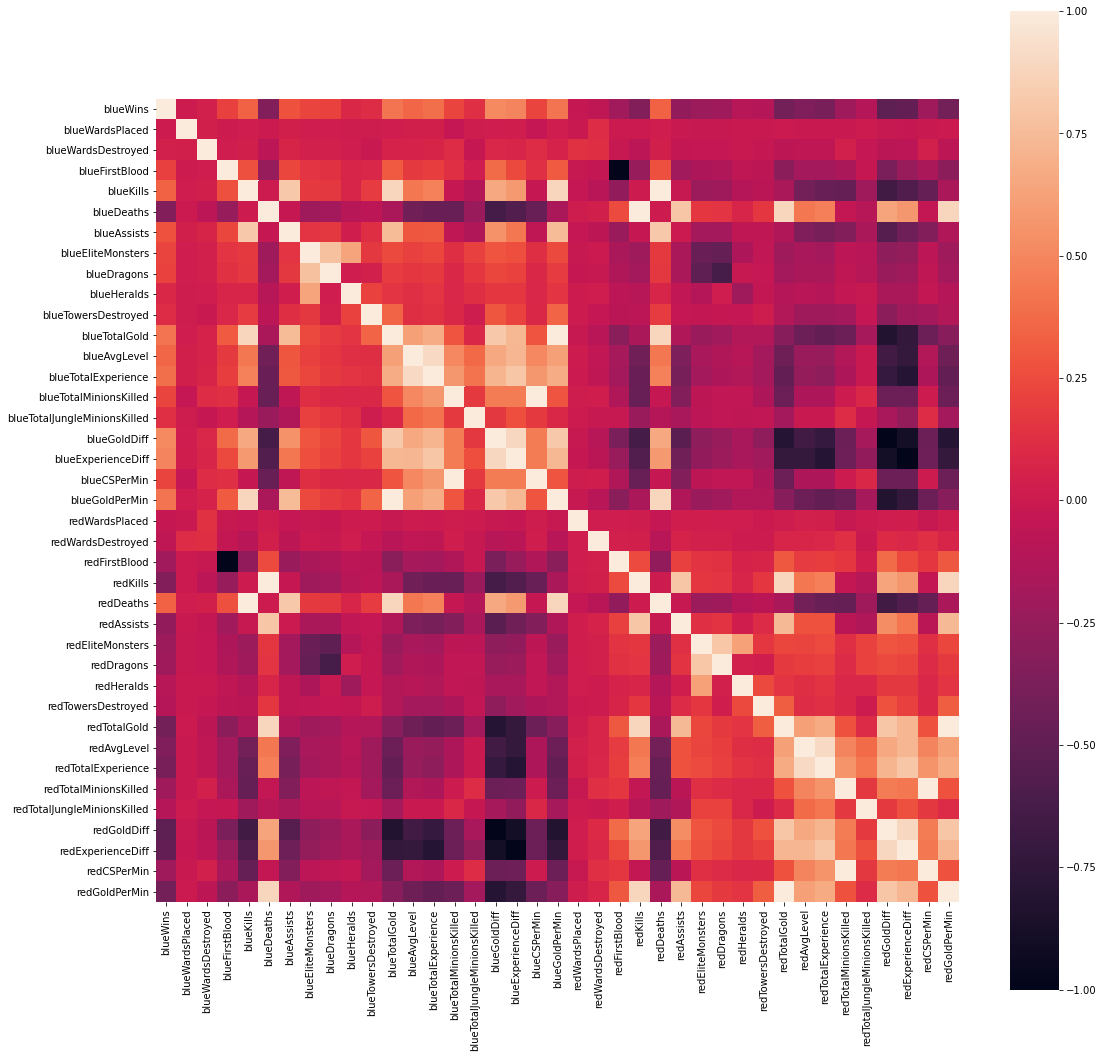

In [5]:
# heatmap
corr = games.corr()

plt.figure(figsize=(18,18))
sns.heatmap(corr, square=True)
plt.show()

## Remove variables that can be calculated by others

* `blueTotalGold`, `blueTotalExperience`, `blueTotalMinionsKilled`, `blueCSPerMin`, `blueGoldPerMin`, `blueAvgLevel`
* `redFirstBlood`, `redGoldDiff`, `redExperienceDiff` `redKills`, `redDeaths`, `redAssists`, `redTotalGold`, `redTotalExperience`, `redTotalMinionsKilled`, `redCSPerMin`, `redGoldPerMin`, `redAvgLevel`

### Some of the reasons are:

Variables such as `CS per min`, `minions kill` are all reflected in `gold differeneces`

`redFirstBlood` and `blueFirstBlood` are complete opposite so only need to keep one of them


In [6]:
games.drop(columns=['blueTotalGold', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueCSPerMin', 'blueGoldPerMin', 'blueAvgLevel'], inplace=True)
games.drop(columns=['redFirstBlood', 'redGoldDiff', 'redExperienceDiff', 'redKills', 'redDeaths', 'redAssists', 'redTotalGold', 
                    'redTotalExperience', 'redTotalMinionsKilled', 'redGoldPerMin', 'redAvgLevel', 'redCSPerMin'], inplace=True)

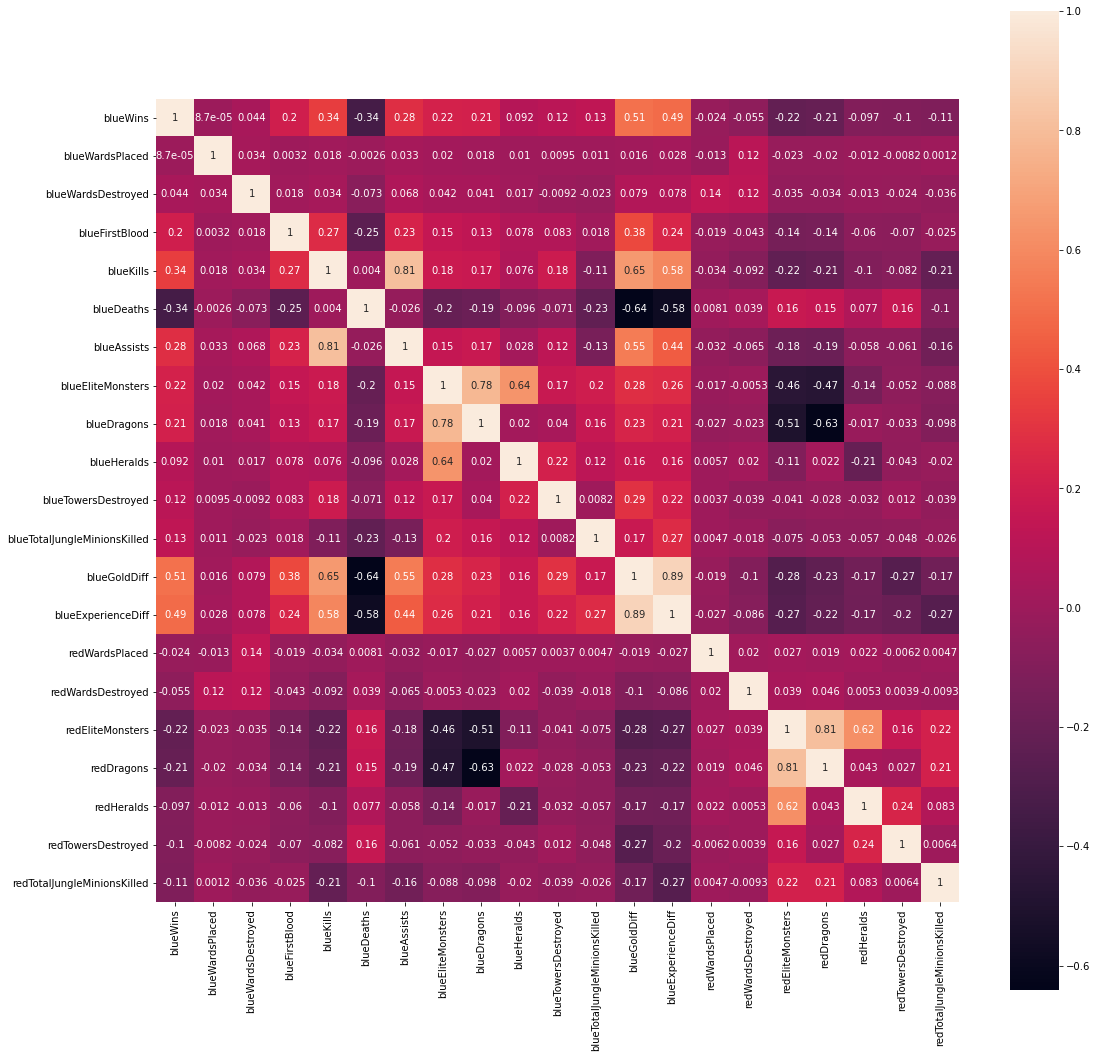

In [7]:
# heatmap
corr = games.corr()

plt.figure(figsize=(18,18))
sns.heatmap(corr, annot=True, square=True)
plt.show()

## Count number of wins on each side, data look quite balanced

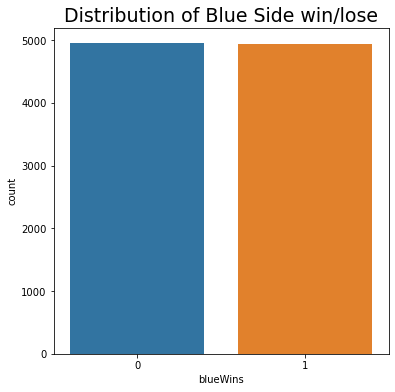

In [8]:
# count blueWins

plt.figure(figsize=(6,6))
sns.countplot(data=games, x='blueWins')
plt.title('Distribution of Blue Side win/lose', size=19)
plt.show()

## Split data into train and test 

In [9]:
# train, test split
X = games.iloc[:,1:]
y = games['blueWins']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('\n')
print('mean gold diff:', x_train['blueGoldDiff'].mean())
print('mean exp diff:', x_train['blueExperienceDiff'].mean())

x_train: (7903, 20)
x_test: (1976, 20)
y_train: (7903,)
y_test: (1976,)


mean gold diff: 19.30191066683538
mean exp diff: -23.5940781981526


## Make sure the classes are balanced

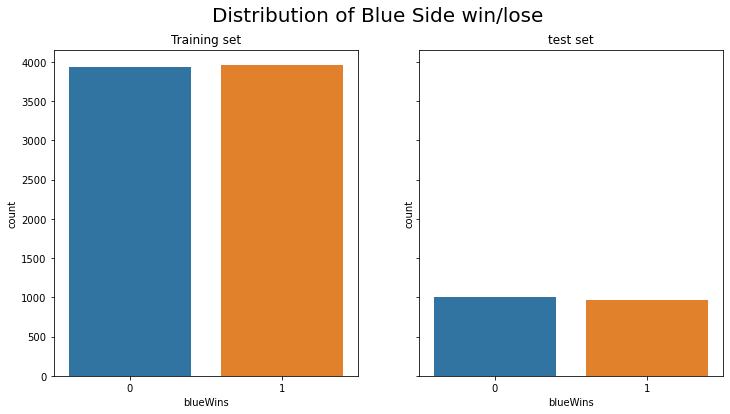

In [10]:
# count blueWins
y_train_count = pd.DataFrame({'blueWins':y_train})
y_test_count = pd.DataFrame({'blueWins':y_test})

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))

sns.countplot(data=y_train_count, x='blueWins', ax=ax1)
ax1.set_title('Training set')
ax1.grid(False)

sns.countplot(data=y_test_count, x='blueWins',ax=ax2)
ax2.set_title('test set')
ax2.grid(False)

plt.suptitle('Distribution of Blue Side win/lose', size=20)
plt.show()

# Random Forest

First fit a basic Random Forest model

In [11]:
model = RandomForestClassifier(random_state=10)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.7181174089068826

## Important features in Random Forest

It seems like `blueGoldDiff` and `blueExperienceDiff` are the most significant factors (this is intuitively correct if you play the game)

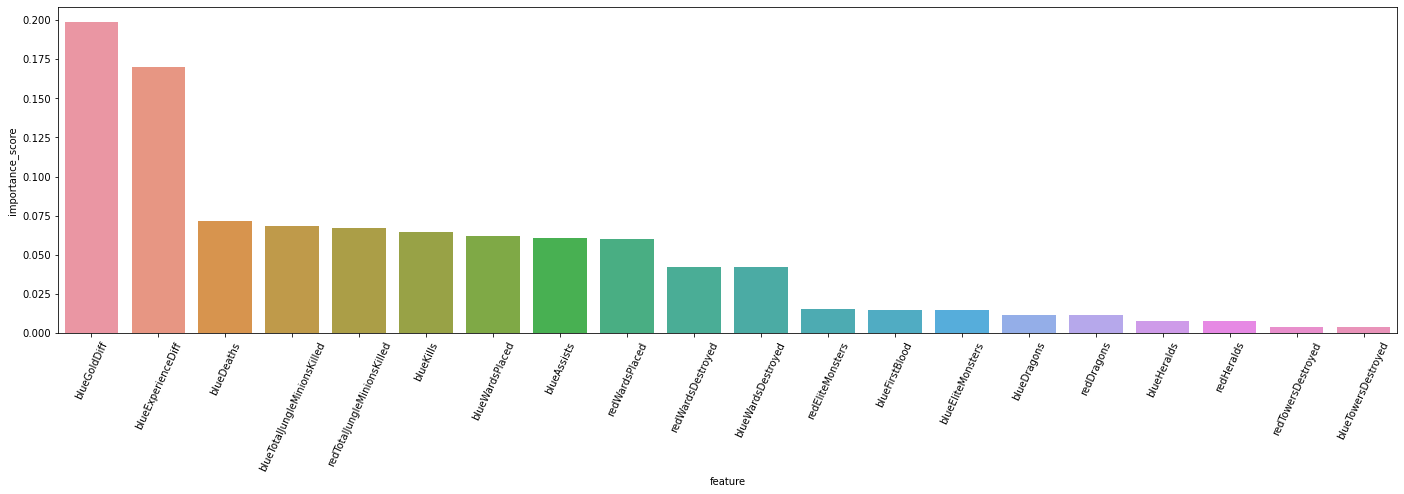

In [12]:
important_features = pd.DataFrame({'feature':x_train.columns, 'importance_score':model.feature_importances_})
important_features.sort_values(by='importance_score', ascending=False, inplace=True)

plt.figure(figsize=(24,6))
p = sns.barplot(data=important_features, x='feature', y='importance_score')

plt.xticks(rotation=65)
plt.show()

## Fine Tuning Hyperparameters using `RandomizedSearchCV`

### This takes a long time to run, uncomment the code if you want to run it yourself

In [13]:
# # set range of parameters for tuning
# n_estimators = [int(x) for x in np.linspace(start=50, stop=2000, num=79)]
# criterion = ['gini', 'entropy']
# max_features = ['auto','sqrt','log2',None]
# max_depth = [int(x) for x in np.linspace(start=5, stop=25, num=20)]
# max_depth.append(None)
# min_samples_split = [2,5,8]
# min_samples_leaf = [1, 2, 4]

# parameters = {'n_estimators' : n_estimators,
#                  'criterion' : criterion,
#                  'max_features' : max_features,
#                  'max_depth' : max_depth,
#                  'min_samples_split' : min_samples_split,
#                  'min_samples_leaf' : min_samples_split}


# rdm_for = RandomForestClassifier()
# rdm_CV = RandomizedSearchCV(rdm_for, parameters, cv=5, n_iter = 10, verbose=1)
# rdm_CV.fit(X,y)

# rdm_CV.best_params_
# # {'n_estimators': 950,
# #  'min_samples_split': 8,
# #  'min_samples_leaf': 1,
# #  'max_features': 'auto',
# #  'max_depth': 7,
# #  'criterion': 'gini'}

### Fit the model using results from random search

In [14]:
model = RandomForestClassifier(n_estimators=950, 
                               min_samples_split=8, 
                               min_samples_leaf=1, 
                               max_features='auto',
                              max_depth=7,
                              criterion='gini',
                              random_state=10)
model.fit(x_train, y_train)
model.score(x_test, y_test)


0.7201417004048583

# Logistic Regression

In [15]:
# logistice regression
clf = LogisticRegression()
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.7160931174089069

## Logistic Regression - Hyperparameter Tuning

In [16]:
# set range of parameters for tuning
C = np.arange(0.00001, 5, 0.1)
penalty = ['l1', 'l2', 'elasticnet', 'none']


parameters = {'C' : C,'penalty' : penalty}


clf = LogisticRegression()
clf_CV = RandomizedSearchCV(clf, parameters, cv=5, n_iter = 10, verbose=1)
clf_CV.fit(X,y)

# clf_CV.best_params_
# {'penalty': 'l2', 'C': 4.50001}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.8s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': array([1.00000e-05, 1.00010e-01, 2.00010e-01, 3.00010e-01, 4.00010e-01,
       5.00010e-01, 6.00010e-01, 7.00010e-01, 8.00010e-01, 9.00010e-01,
       1.00001e+00, 1.10001e+00, 1.20001e+00, 1.30001e+00, 1.40001e+00,
       1.50001e+00, 1.60001e+00, 1.70001e+00, 1.80001e+00, 1.90001e+00,
       2.00001e+00, 2.10001e+00...
       2.50001e+00, 2.60001e+00, 2.70001e+00, 2.80001e+00, 2.90001e+00,
       3.00001e+00, 3.10001e+00, 3.20001e+00, 3.30001e+00, 3.40001e+00,
       3.50001e+00, 3.60001e+00, 3.70001e+00, 3.80001e+00, 3.90001e+00,
       4.00001e+00, 4.10001e+00, 4.20001e+00, 4.30001e+00, 4.40001e+00,
       4.50001e+00, 4.60001e+00, 4.70001e+00, 4.80001e+00, 4.90001e+00]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none']},
                   verbose=1)

In [17]:
# logistice regression after fine tuning
clf = LogisticRegression(penalty='l2', C=4.5)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.7135627530364372

## Principal Component Analysis (PCA)

### Standardize the data, then perform PCA

In [18]:
# make a copy of data, set gameId to index
games = games_source.copy()
games.drop(columns='gameId', inplace=True)

X = games.iloc[:,1:]
y = games['blueWins']


# Standardize
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X_scaled)


PCA(n_components='mle', svd_solver='full')

## Explained variance by each component

* The first component is fairly dominant compare to others, explaining over 30% of total variance
* The first 15 components explains over 90% of total variance

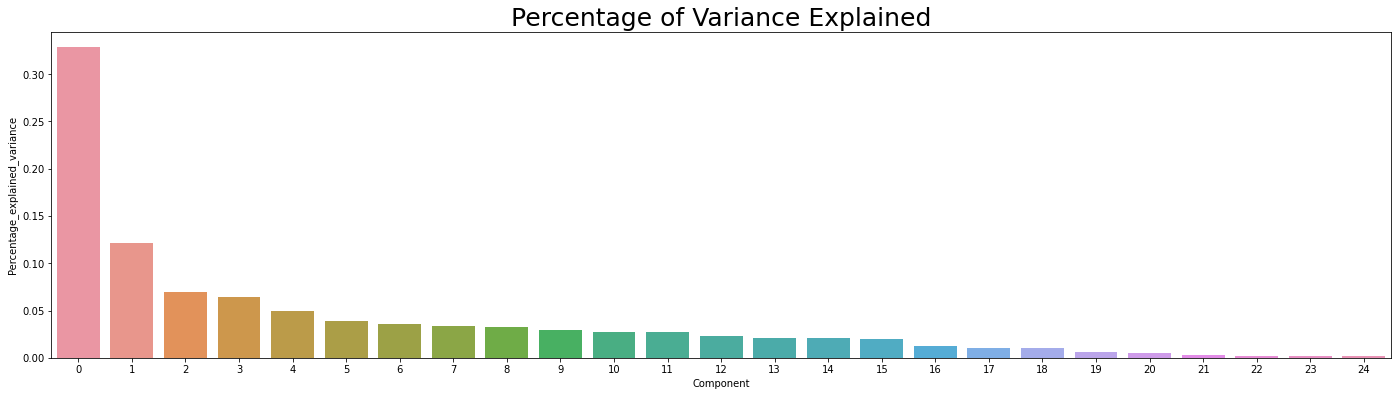

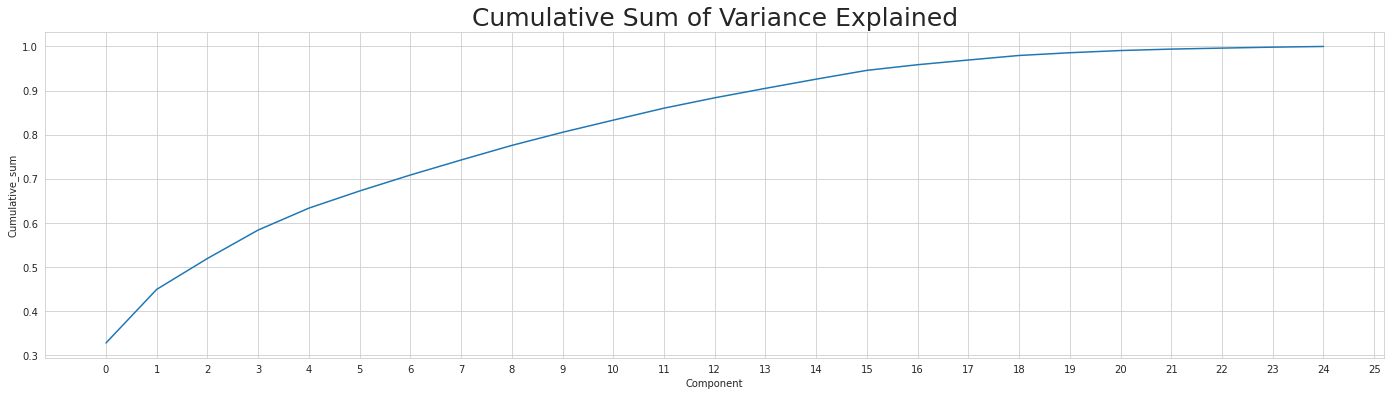

In [19]:
# var ratio
variance_ratio = pd.DataFrame({'Component':range(0,25), 'Percentage_explained_variance':pca.explained_variance_ratio_})
variance_ratio

plt.figure(figsize=(24,6))
sns.barplot(data=variance_ratio, x='Component', y='Percentage_explained_variance')
plt.title('Percentage of Variance Explained', size=25)
plt.show()

# cumulative sum
cumsum_ratio = pd.DataFrame({'Component':range(0,25), 'Cumulative_sum':pca.explained_variance_ratio_.cumsum()})

plt.figure(figsize=(24,6))
sns.set_style("whitegrid")
sns.lineplot(data=cumsum_ratio, x='Component', y='Cumulative_sum')
plt.title('Cumulative Sum of Variance Explained', size=25)
plt.xticks(np.arange(0,26, step=1))
plt.show()

## Examine important features in first few components

### Take a look at highest eigenvalues in the first few components, identify important features

### Component 1

* Gold difference 
* Experience difference

In [20]:
aa = pd.DataFrame({'feature':X.columns, 'eigenvalue': abs(pca.components_[0])})
aa.sort_values(by='eigenvalue', ascending=False).head(10)

feature  eigenvalue
15         blueGoldDiff    0.277441
34          redGoldDiff    0.277441
35    redExperienceDiff    0.266243
16   blueExperienceDiff    0.266243
18       blueGoldPerMin    0.226717
10        blueTotalGold    0.226717
29         redTotalGold    0.223054
37        redGoldPerMin    0.223054
12  blueTotalExperience    0.213231
31   redTotalExperience    0.212999

### Component 2

* Kills / Deaths / Assists

In [21]:
aa = pd.DataFrame({'feature':X.columns, 'eigenvalue': abs(pca.components_[1])})
aa.sort_values(by='eigenvalue', ascending=False).head(10)

feature  eigenvalue
22                redKills    0.316141
4               blueDeaths    0.316141
3                blueKills    0.309181
23               redDeaths    0.309181
24              redAssists    0.279429
5              blueAssists    0.272112
17            blueCSPerMin    0.228411
13  blueTotalMinionsKilled    0.228411
36             redCSPerMin    0.226799
32   redTotalMinionsKilled    0.226799

### Component 3

* Elite monsters, includes dragons and Heralds
* Interestingly the eigenvalue is not that big for Heralds, this might be due to early tower damage does not have hugh impact unless the team can snowball really well with the vision advantage. Or the Herald could be traded with Dragon kill from the other team, but Dragons are more valuable.

In [22]:
aa = pd.DataFrame({'feature':X.columns, 'eigenvalue': abs(pca.components_[2])})
aa.sort_values(by='eigenvalue', ascending=False).head(10)

feature  eigenvalue
25             redEliteMonsters    0.470150
26                   redDragons    0.455089
7                   blueDragons    0.451991
6             blueEliteMonsters    0.446963
27                   redHeralds    0.192133
8                   blueHeralds    0.159610
17                 blueCSPerMin    0.110573
13       blueTotalMinionsKilled    0.110573
33  redTotalJungleMinionsKilled    0.110266
12          blueTotalExperience    0.085949

### Component 4

* Again, experience of players (equivalent to average level)

In [23]:
aa = pd.DataFrame({'feature':X.columns, 'eigenvalue': abs(pca.components_[3])})
aa.sort_values(by='eigenvalue', ascending=False).head(10)

feature  eigenvalue
31      redTotalExperience    0.332687
12     blueTotalExperience    0.324865
30             redAvgLevel    0.321751
11            blueAvgLevel    0.317883
32   redTotalMinionsKilled    0.259504
36             redCSPerMin    0.259504
17            blueCSPerMin    0.238690
13  blueTotalMinionsKilled    0.238690
37           redGoldPerMin    0.214427
29            redTotalGold    0.214427

## Fitting Random Forest using the PCA transformed X

In [24]:
new_x = pca.transform(X_scaled)
new_x = pd.DataFrame(new_x)
new_x

0         1         2         3         4         5         6   \
0    -0.752777  2.393919 -0.114726  1.820820 -1.669618 -0.474753 -1.219832   
1     4.113111 -0.232675  1.841279  2.090242 -0.464073 -2.498079  4.538072   
2     2.176679  3.251619 -2.485291  2.136325  1.813148 -0.145678 -0.239827   
3     1.251326 -0.988898 -1.714263  0.111806  1.623818  0.564291  0.537196   
4     1.198084 -0.298521  1.631960 -0.906831  0.977694 -0.562030 -0.184612   
...        ...       ...       ...       ...       ...       ...       ...   
9874 -3.552857 -0.554755 -1.643110 -0.156952 -0.096500 -0.754986 -0.108101   
9875 -1.529951 -1.552413 -1.198992 -0.953584  1.662560 -0.689933 -0.769553   
9876  3.942824 -0.276517  1.097611 -2.252235  0.148167 -0.899292 -0.415435   
9877  1.024353 -3.631774 -2.611301  0.883666 -1.441635 -0.363956 -0.658284   
9878 -0.573775  0.004464  1.498034  2.017484 -1.316484  0.530210 -0.530084   

            7         8         9   ...        15        16        17  \
0     0.434775  0.745907  0.592353  ...  0.261392  0.369714  0.938890   
1     0.370264 -0.592516 -0.484780  ... -0.281766  0.139443 -0.395544   
2    -0.366458 -0.619523 -1.017622  ... -0.561541 -0.345762 -0.761225   
3     1.968502 -0.294990 -0.593529  ... -1.063897  1.028401  1.208528   
4     1.474498  0.353115  0.295623  ...  0.310722 -0.796979  0.337193   
...        ...       ...       ...  ...       ...       ...       ...   
9874  0.168457  0.118285 -2.400264  ... -0.153335 -0.503953 -0.335666   
9875 -0.032391  3.700254  0.116185  ...  0.901070  0.521412 -0.797353   
9876  1.668158 -1.287539  0.601583  ... -0.748024 -0.450877 -0.241233   
9877 -0.728841  1.552108 -0.010925  ... -0.814907 -0.030287 -1.079897   
9878  0.561363 -1.139854 -0.701669  ... -0.299884  0.286465 -1.057751   

            18        19        20        21        22        23        24  
0    -0.039170  0.161763  0.301713 -0.318862  0.103454 -0.060023  0.271189  
1    -0.486826 -0.324291 -0.141564 -0.062800  0.128466  0.231948  0.109482  
2     0.206677 -0.273744  0.944627  0.237296 -0.412272  0.045137 -0.174734  
3    -0.298235  1.068452  0.252981  0.071986  0.122635  0.003052 -0.070138  
4    -0.531742 -0.249182  0.106442 -0.234924  0.234304 -0.073749  0.212610  
...        ...       ...       ...       ...       ...       ...       ...  
9874 -0.280803  0.112647  0.871008  0.016511 -0.394027  0.416250  0.394368  
9875 -0.101471  0.433953 -0.492014 -0.195880  0.100747 -0.380112 -0.188418  
9876 -0.710592  0.478900  0.655839  0.270944  0.303387 -0.038134  0.046696  
9877  0.415674  0.047445  0.036675 -0.680390 -0.003939  0.009742  0.023886  
9878 -0.097059 -0.129631 -0.268784  0.431522 -0.261283  0.349849  0.021430  

[9879 rows x 25 columns]

In [25]:
# train, test split
X = new_x.copy()
y = games['blueWins']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (7903, 25)
x_test: (1976, 25)
y_train: (7903,)
y_test: (1976,)


### Not much of improvement

In [26]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)


0.7135627530364372

# Conclusion

**Gold Difference** and **Experience Difference** are the two greatest factors in the game, any actions that enlarge the gap of gold and experience will help teams towards victory.

Regarding prediction accuracy, is it impossible to be close to 100% because the data is only for first 10 minutes and an average game can last between 25 -35 minutes. Also comebacks do happen from time to time and numerical advantage on certain stats does not guarantee victory.